In [2]:
import pandas as pd
import numpy as np
import sqlite3
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, classification_report, roc_auc_score, f1_score, log_loss, recall_score, accuracy_score, precision_score, make_scorer, precision_recall_fscore_support
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.layers import LSTM, BatchNormalization, Conv2D, Conv1D, Flatten, MaxPooling2D, GlobalAveragePooling2D, Dropout, Bidirectional, Dense, Input
from keras.models import Sequential, Model
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from keras.callbacks import EarlyStopping, TensorBoard
from sklearn.manifold import TSNE
from keras.utils import to_categorical
from keras.regularizers import l1
import warnings
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV
from collections import defaultdict


In [3]:
#thomas
# Upload faulty training dataset
df = pd.read_csv(r'D:\OneDrive - Alberta Innovates\school\machine learning - 788\final project\TEP_Faulty_Training.csv', on_bad_lines='skip')

# Upload the fault-free training dataset
df2 = pd.read_csv(r'D:\OneDrive - Alberta Innovates\school\machine learning - 788\final project\TEP_FaultFree_Training.csv', on_bad_lines='skip')

# Upload the faulty testing dataset
df_test = pd.read_csv(r'D:\OneDrive - Alberta Innovates\school\machine learning - 788\final project\TEP_Faulty_Testing.csv', on_bad_lines='skip')

# Upload the fault-free training dataset
df2_test = pd.read_csv(r'D:\OneDrive - Alberta Innovates\school\machine learning - 788\final project\TEP_FaultFree_Testing.csv', on_bad_lines='skip')

In [6]:
#Sub-sample (20)
df = df.loc[(df['simulationRun']<21),:]
df2 = df2.loc[(df2['simulationRun']<21),:]

df_test = df_test.loc[(df_test['simulationRun']<21),:]
df2_test = df2_test.loc[(df2_test['simulationRun']<21),:]

#Combine Test data
combined_df_test = pd.concat([df_test, df2_test], ignore_index=True)

#Combine Training data
combined_df = pd.concat([df, df2], ignore_index=True)

In [7]:
#EDA FOR RF
features_to_plot = ['xmeas_2','xmeas_5', 'xmeas_12', 'xmeas_14', 'xmeas_15', 'xmeas_17', 'xmeas_37','xmv_7', 'xmv_8']

def featureengg(combined_df, features_to_plot):

    # Assuming combined_df, features_to_plot are defined earlier
    clean_df = combined_df.drop(columns=features_to_plot).copy()

    window_size = 20  #Window size
    j = [2, 4, 6, 8]  # Lag intervals

    new_columns = defaultdict(list)

    # Loop through faults and runs
    for fault in clean_df['faultNumber'].unique():
        for run in clean_df[clean_df['faultNumber'] == fault]['simulationRun'].unique():
            mask = (clean_df['faultNumber'] == fault) & (clean_df['simulationRun'] == run)

            for feature in clean_df.columns.difference(['faultNumber', 'simulationRun', 'sample']):
                frequency_feat = [np.nan] * len(clean_df.loc[mask, feature])
                feature_ma = f'{feature}_MA'
                feature_std = f'{feature}_STD'

                # Calculate moving average and standard deviation
                ma = clean_df.loc[mask, feature].rolling(window=window_size, min_periods=1).mean()
                std = clean_df.loc[mask, feature].rolling(window=window_size, min_periods=1).std()


                new_columns[feature_ma].extend(ma)
                new_columns[feature_std].extend(std)

                # Calculate and store lagged features
                for i in j:
                    lag_name = f'{feature}_lag{i}'
                    lag = clean_df.loc[mask, feature].shift(i)
                    new_columns[lag_name].extend(lag)

                #Calculate the FFT
                feature_f = f'{feature}_frequency'
                for i in range(len(clean_df.loc[mask, feature])):
                    if i < window_size:
                        frequency_feat[i] = np.nan
                    else:
                        frequency_feat[i] = np.abs(np.fft.fft(clean_df.loc[mask, feature][i-window_size:i])[1:]).max()

                new_columns[feature_f].extend(frequency_feat)

    for key in new_columns:
        new_columns[key] = pd.Series(new_columns[key], index=clean_df.index)

    new_columns_df = pd.DataFrame(new_columns)
    clean_df = pd.concat([clean_df, new_columns_df], axis=1)
    return clean_df

In [8]:
#Feature engineering of Training Data
clean_df = featureengg(combined_df, features_to_plot)

#For Binary classification
clean_df_cleaned = clean_df.dropna(axis=0)
clean_df_cleaned['faultNumber'] = (clean_df_cleaned['faultNumber'] > 0).astype(int)
comb_x_df = clean_df_cleaned.drop(columns=['faultNumber','simulationRun','sample'])
comb_y_df = clean_df_cleaned['faultNumber']

#Feature engineering of Testing Data
clean_df_test = featureengg(combined_df_test, features_to_plot)

#For Binary classification
clean_df_test_cleaned = clean_df_test.dropna(axis=0)
clean_df_test_cleaned['faultNumber'] = (clean_df_test_cleaned['faultNumber'] > 0).astype(int)
comb_x_df_test = clean_df_test_cleaned.drop(columns=['faultNumber','simulationRun','sample'])
comb_y_df_test = clean_df_test_cleaned['faultNumber']

C:\Users\kamin\AppData\Local\Temp\ipykernel_10532\1317679147.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df_cleaned['faultNumber'] = (clean_df_cleaned['faultNumber'] > 0).astype(int)
C:\Users\kamin\AppData\Local\Temp\ipykernel_10532\1317679147.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df_test_cleaned['faultNumber'] = (clean_df_test_cleaned['faultNumber'] > 0).astype(int)


In [9]:
#For Binary classification

A1 = Pipeline([('A_',StandardScaler(with_mean=False))])
clf = RandomForestClassifier(n_estimators=200, max_depth=40)

full_pipeline_Kbest = Pipeline([('initial_transform', A1), ('RFR', clf)])
X_new=full_pipeline_Kbest.fit(comb_x_df, comb_y_df)

Accuracy: 0.9702410714285714


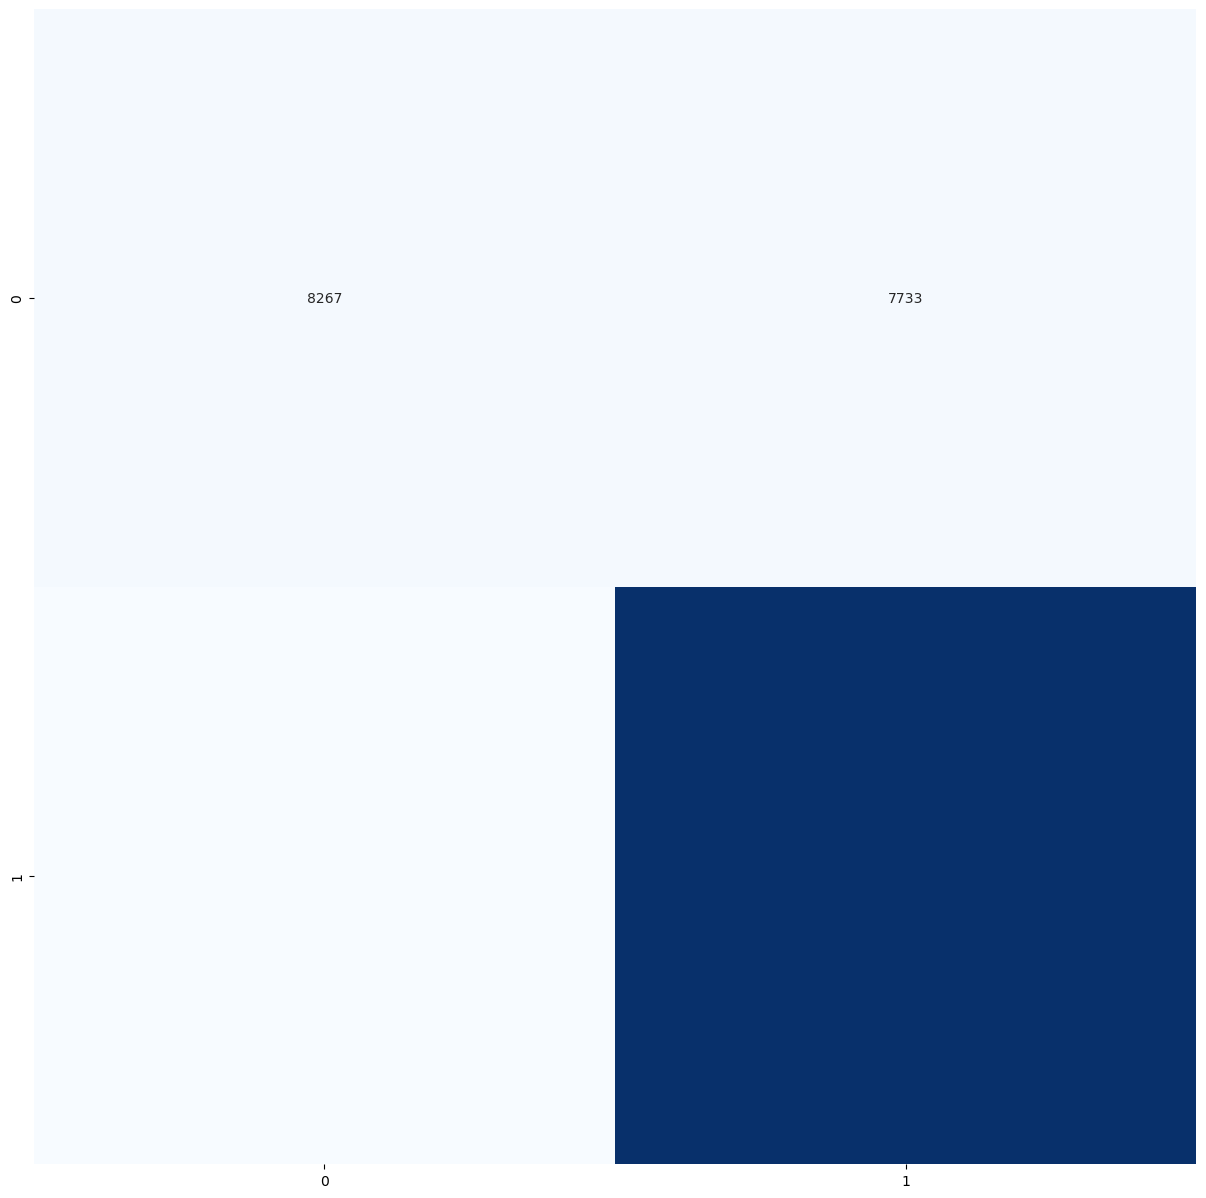

Precision: 0.8428510201358267
Recall: 0.8398404255319148
F1-Score: 0.7948568370715551
Accuracy: 0.8398404255319148
        Actual  Predicted  Correct  sample  simulationRun
20           0          1     True      21              1
21           0          1     True      22              1
22           0          1     True      23              1
23           0          1     True      24              1
24           0          1     True      25              1
...        ...        ...      ...     ...            ...
403195       0          1    False     956             20
403196       0          1    False     957             20
403197       0          1    False     958             20
403198       0          1    False     959             20
403199       0          1    False     960             20

[394800 rows x 5 columns]


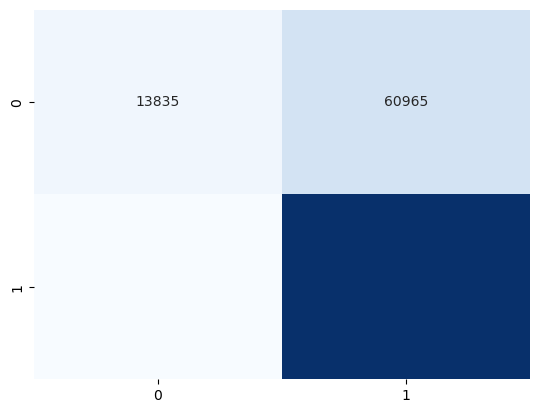

In [11]:
#Results for binary model
predictions = full_pipeline_Kbest.predict(comb_x_df_test)
results_df = pd.DataFrame({
    'Actual': comb_y_df_test,
    'Predicted': predictions,
    'Correct': comb_y_df_test == predictions,
})


results_df['sample'] = clean_df_test_cleaned['sample']
results_df['simulationRun'] = clean_df_test_cleaned['simulationRun']

plt.figure(figsize=(15, 15))
conf_matrix = confusion_matrix(results_df.loc[results_df['sample']>160,'Actual'],
                               results_df.loc[results_df['sample']>160,'Predicted'])
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)

accuracy = accuracy_score(results_df.loc[results_df['sample']>160,'Actual'],
                               results_df.loc[results_df['sample']>160,'Predicted'])
print(f"Accuracy: {accuracy}")

plt.show()
anotherone = results_df.loc[results_df['sample']>160].groupby(['Actual']).agg({'Predicted':'count', 'Correct':'sum'})
anotherone['accuracy'] = anotherone['Correct']/anotherone['Predicted']

results_df.loc[results_df['sample'] < 161, 'Actual'] = 0
conf_matrix =confusion_matrix(results_df['Actual'],
                               results_df['Predicted'])
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
precision, recall, f1, _ = precision_recall_fscore_support(results_df['Actual'], results_df['Predicted'], average='weighted')
print(f"Precision: {precision}\nRecall: {recall}\nF1-Score: {f1}")

# Accuracy
accuracy = accuracy_score(results_df['Actual'], results_df['Predicted'])
print(f"Accuracy: {accuracy}")

anotherone = results_df.loc[results_df['sample']>160].groupby(['Actual']).agg({'Predicted':'count', 'Correct':'sum'})
anotherone['accuracy'] = anotherone['Correct']/anotherone['Predicted']

print(results_df)

Precision: 0.8428510201358267
Recall: 0.8398404255319148
F1-Score: 0.7948568370715551
Accuracy: 0.8398404255319148


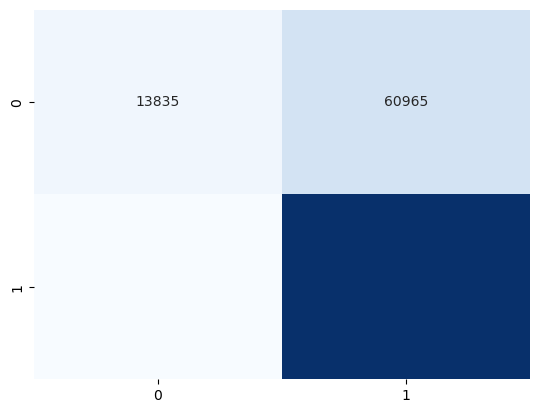

In [12]:
#More results for binary model
results_df.loc[results_df['sample'] < 161, 'Actual'] = 0
conf_matrix =confusion_matrix(results_df['Actual'],
                               results_df['Predicted'])
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
precision, recall, f1, _ = precision_recall_fscore_support(results_df['Actual'], results_df['Predicted'], average='weighted')
print(f"Precision: {precision}\nRecall: {recall}\nF1-Score: {f1}")

# Accuracy
accuracy = accuracy_score(results_df['Actual'], results_df['Predicted'])
print(f"Accuracy: {accuracy}")